# Women's participation in NSF Ocean Sciences awards
Created by Ivan Lima on Tue Mar 16 2021 20:37:23 -0400

In this notebook we examine women's representation in NSF Ocean Sciences awards in the period 1987-2019. We measure women's participation as the percentage of women PIs and co-PIs in the awards. These two metrics provide complementary information on the gender composition of the awards and we track how they vary across:

 1. Time
 2. The 10 largest NSF-OCE programs (in number of awards)
 2. Indentified research topics (using topic modeling)
 3. Different award types

We also look at the relative frequency of the different categories (e.g. programs, topics and award types) within each gender (PIs). The relative frequency of different NSF-OCE programs, research topics and award types within a given gender shows how that gender distributes hers/his awards and therefore provides information on the gender's makeup in terms of scientific disciplines and type of research and activity. Specifically, we look at the ratio between the percentage of awards allocated by women PIs and men PIs to each category (program, topic and award type). A ratio greater than one means that women PIs apportion a higher proportion of their awards to that category than men do, and therefore likely have a higher percentage of PIs in that category than men. Conversely, a ratio smaller than one means that men have a higher proportion of PIs in that category than women.

<!--The annual data can be noisy due to the small number of awards (1 to 3) in certain categories in a given year. So in the visualizations for the NSF-OCE programs, research topics and award types below we group and average the data in 3-year periods. The year shown in the slide bar represents the end of the 3-year period.-->

This work is being done in collaboration with Jennie Rheuban and we have submitted a manuscript for publication in *Oceanography* magazine. For more information and analyses see our [GitHub repository](https://github.com/WHOIGit/nsf-oce-gender). 

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import datetime
import plotly.io as pio
pio.templates.default = 'plotly_white'
pd.options.display.max_columns = 30
print('Last updated on {}'.format(datetime.datetime.now().ctime()))

Last updated on Fri Jul 30 16:37:57 2021


In [2]:
# Read NSF-OCE award data
data_types = {'Abstract':'string', 'Title':'string', 'Programs':'string', 'PI':'string',
              'Organization':'string', 'State':'string', 'Instrument':'string', 'co-PIs':'string',
              'program':'string', 'PI_first_name':'string', 'co-PI_first_name':'string',
              'PI_gender':'string', 'co-PI_gender':'string', 'award_type':'string'}
awards = pd.read_csv('results/awards_1985-2020_clean_edited_grouped_gender_topic.csv', index_col=0,
                     parse_dates=[4,5], dtype=data_types)
awards['year'] = awards.StartDate.dt.year
awards.loc[awards.program=='DATA NOT AVAILABLE','program'] = np.nan

periods = np.array([[y,]*3 for y in range(1989,2021,3)]).flatten() # 3-year periods
years = np.arange(1987,2020)
year_to_period = {y:p for y,p in zip(years,periods)}
awards['period'] = awards.year.map(year_to_period) # map year to period

npzfile = np.load('results/NMF_TSNE.npz')
topic_names    = npzfile['topic_names']
topic_names_r  = npzfile['topic_names_r']
feature_names  = npzfile['feature_names']
nmf_components = npzfile['nmf_components']
npzfile.close()

# Read geosciences/atmospheric/ocean sciences academic gender workforce data
workforce = pd.read_csv('data/nsf_workforce.csv')#, index_col=0)
workforce['female_frac'] = workforce.female/workforce.total
workforce['female_pct'] = workforce['female_frac'] * 100
workforce = workforce.set_index('year')

## Temporal trends in women's participation

The figure below shows the annual mean percentages of women PIs and co-PIs in NSF-OCE awards, and in the academic workforce for earth, atmospheric and ocean sciences.

The difference between the temporal trends (slopes) in the percentages of women PIs and co-PIs is not statistically significant. Overall, women’s participation in NSF-OCE awards has been growing at a rate of approximately 0.64% per year, and the similarity between the temporal trends in the NSF-OCE awards and the academic workforce suggests that the observed upward trend in women representation in NSF-OCE awards is a reflection of the increasing participation of women in the ocean sciences academic workforce and that there is no gender bias in NSF funding.

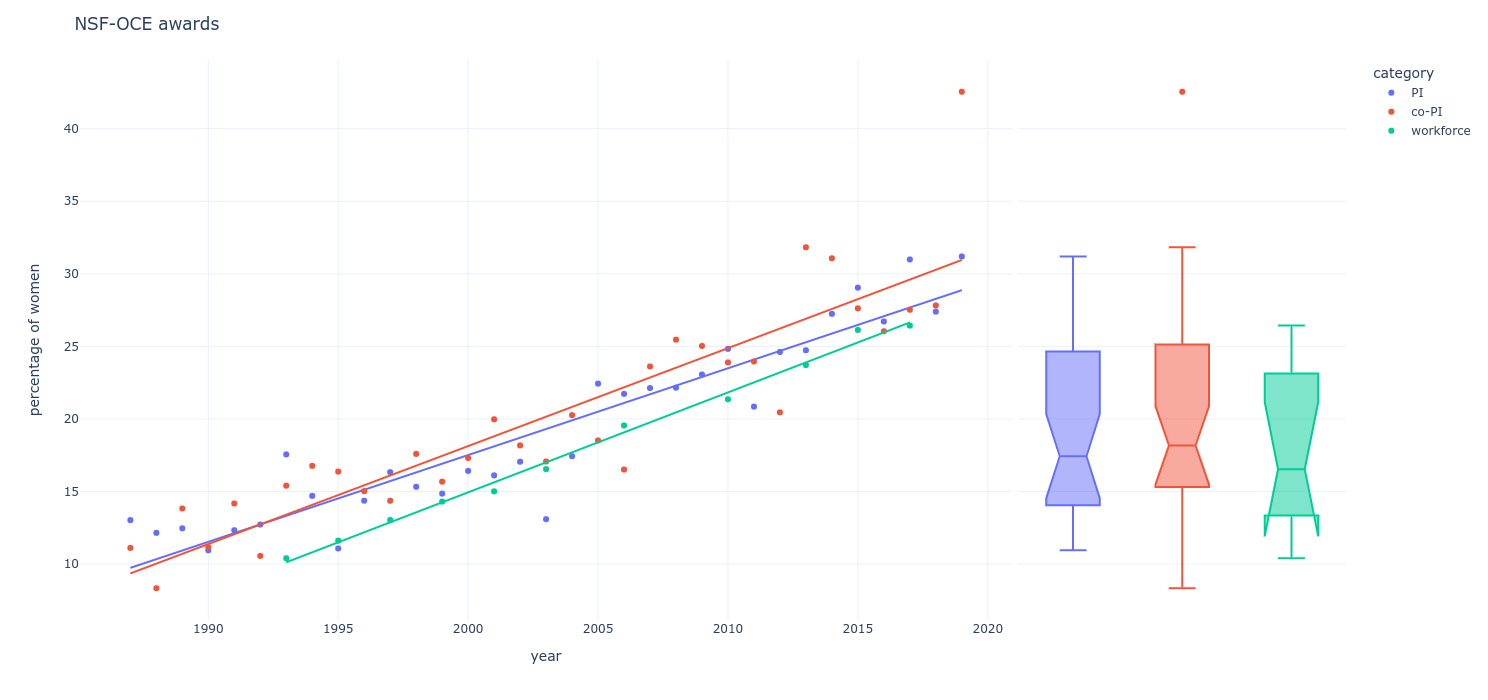

In [3]:
# female & male fraction of PIs
pi_gender = awards.groupby(['year','PI_gender'])['Abstract'].count().unstack()
pi_gender = pi_gender.divide(pi_gender.sum(axis=1), axis=0) * 100 # fraction -> percentage

# female & male fraction of co-PIs
copi_gender = pd.DataFrame({'female':awards.groupby('year')['co-PI_female_frac'].mean()})
copi_gender = copi_gender * 100 # fraction -> percentage

# combine PI, co-PI and workforce data into one dataframe
df_all = pd.concat([pi_gender.female.rename('PI'), copi_gender.female.rename('co-PI'), workforce.female_pct.rename('workforce')], axis=1).stack()
df_all = df_all.reset_index().rename(columns={'level_1':'category',0:'percentage'})

fig = px.scatter(df_all, x='year', y='percentage', color='category', marginal_y='box',
                 trendline='ols', width=1000, height=700)
fig.update_layout(yaxis=dict(title='percentage of women'), title='NSF-OCE awards')
fig.show()

## Women's participation across NSF-OCE programs

In [4]:
# find top 10 programs in number of awards
top10_programs = pd.DataFrame({'number of awards': awards.program.value_counts()[:10]})

# select awards in top 10 programs
awards_top10 = awards[awards.program.isin(top10_programs.index)]

# compute percentage of women PIs per year & program
df = awards_top10.groupby(['period', 'program', 'PI_gender'])['Abstract'].count().unstack().fillna(0)
df_pi = df.divide(df.sum(axis=1), axis=0) * 100
df_pi = df_pi['female'].unstack().stack(dropna=False)

# compute the ratio between the percentage of awards allocated by women PIs and men PIs to each program per year
df_work = df.divide(df.groupby('period').sum(), axis=0)
df_ratio = df_work.female/df_work.male
df_ratio = df_ratio.unstack().stack(dropna=False)
df_ratio = df_ratio.replace([np.inf, -np.inf], np.nan)

# compute percentage of women co-PIs per year & program
df_copi = awards_top10.groupby(['period', 'program'])['co-PI_female_frac'].mean().fillna(0) * 100
df_copi = df_copi.unstack().stack(dropna=False)

# compute number of proposals per year & award type
df_num = awards_top10.groupby(['period', 'program'])['Abstract'].count().fillna(0)
df_num = df_num.unstack().stack(dropna=False).fillna(0)

# df_pi = df_pi.unstack().rolling(window=3, center=True, min_periods=1).mean().stack()
# df_copi = df_copi.unstack().rolling(window=3, center=True, min_periods=1).mean().stack()
# df_ratio = df_ratio.unstack().rolling(window=3, center=True, min_periods=1).mean().stack()
# df_num = df_num.unstack().rolling(window=3, center=True, min_periods=1).mean().stack()
# df_num[df_num == 0] = np.nan
# df_num = df_num.round()

# combine data into one dataframe
iterables = [range(1989,2021,3), top10_programs.index]
# iterables = [range(1988,2019), top10_programs.index]
inds = pd.MultiIndex.from_product(iterables, names=['year', 'program']) # reorder indices
df_programs = pd.concat([df_pi, df_copi, df_ratio, df_num], keys=['PI', 'co-PI', 'ratio', 'number'], axis=1).reindex(inds).reset_index()

The figure below shows the percentage of women PIs vs co-PIs for the 10 largest NSF-OCE programs (in number of awards) from 1987 to 2019. The marker color represents the ratio between the percentage of awards allocated by women PIs and men PIs to that program. A ratio greater than one indicates that the proportion of women PIs in that category is higher than that of men PIs. The annual data can be noisy due to the small number of awards (1 to 3) in certain categories in a given year. So in the visualization below we group and average the data in 3-year periods. The year shown in the slide bar represents the end of the 3-year period.

Women’s participation and its evolution over time varies significantly across the 10 largest NSF-OCE programs. The program related to education (EHR) shows the strongest growth, with women’s participation achieving and surpassing parity with men. The programs related to the acquisition of shared instrumentation and equipment for research vessels have the lowest women’s representation and show relatively little change over time. There is a substantial increase in women's participation over the 33-year period. However, changes in specific programs over short periods of time are often uneven and erratic. Women's representation tends to higher in those programs for which the proportion of women PIs is larger than that of men, and vice-versa

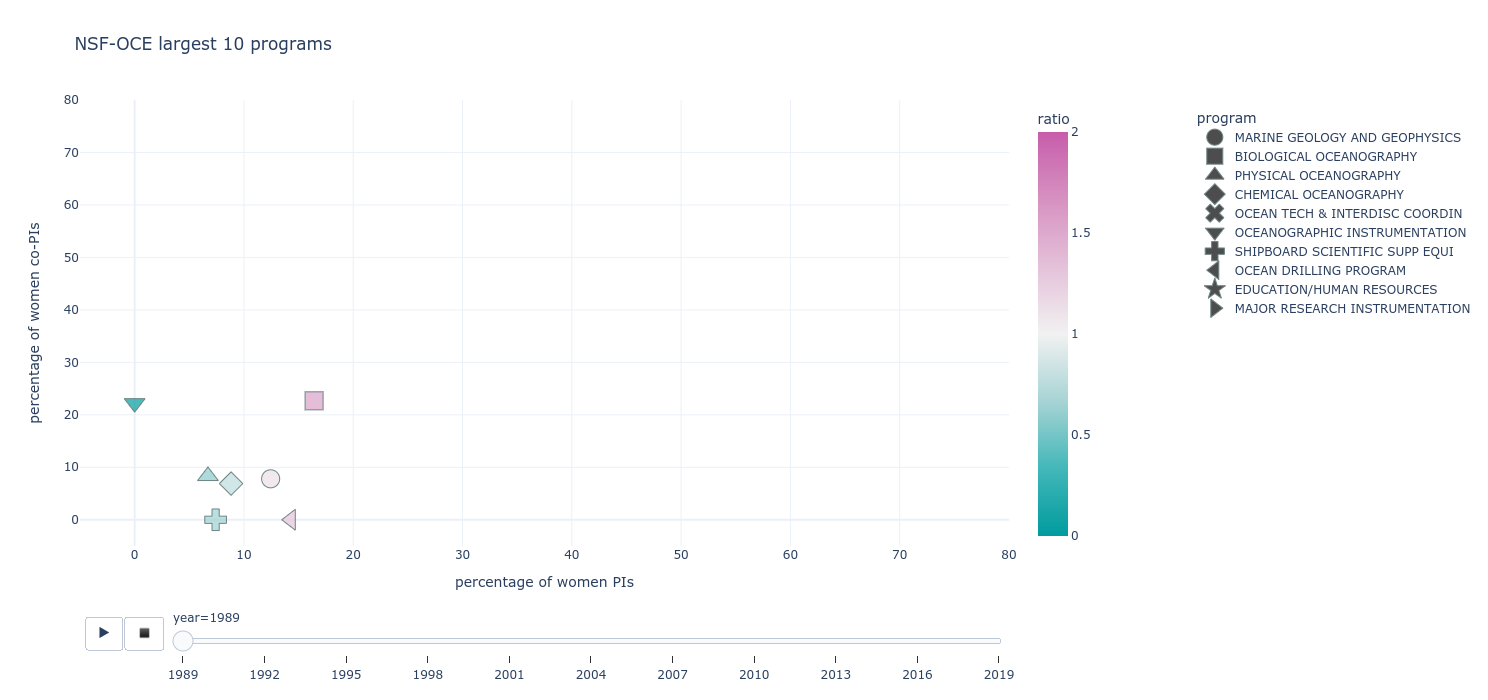

In [5]:
symbols = ['circle','square','triangle-up','diamond','x','triangle-down','cross','triangle-left','star','triangle-right']
fig = px.scatter(df_programs, x='PI', y='co-PI', animation_frame='year', animation_group='program', symbol='program',
                 color='ratio', range_x=[-5,80], range_y=[-5,80], width=900, height=700, symbol_sequence=symbols,
                 color_continuous_scale='Tropic', color_continuous_midpoint=1, title='NSF-OCE largest 10 programs',
                 hover_data={'ratio':':.2f', 'PI':':.1f', 'co-PI':':.1f', 'number':':d'}, opacity=0.7)
fig.update_traces(marker=dict(size=18,line=dict(width=1,color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.update_layout(legend=dict(yanchor='top', y=0.99, xanchor='left', x=1.2),
                  xaxis=dict(title='percentage of women PIs', tickvals=np.arange(0,90,10)), yaxis=dict(title='percentage of women co-PIs'))
fig.show()

The figure below shows in more detail the percentage of women PIs for the 10 largest NSF-OCE programs from 1987 to 2019. The data is grouped and averaged in 3-year periods. The year shown in the slide bar represents the end of the 3-year period.

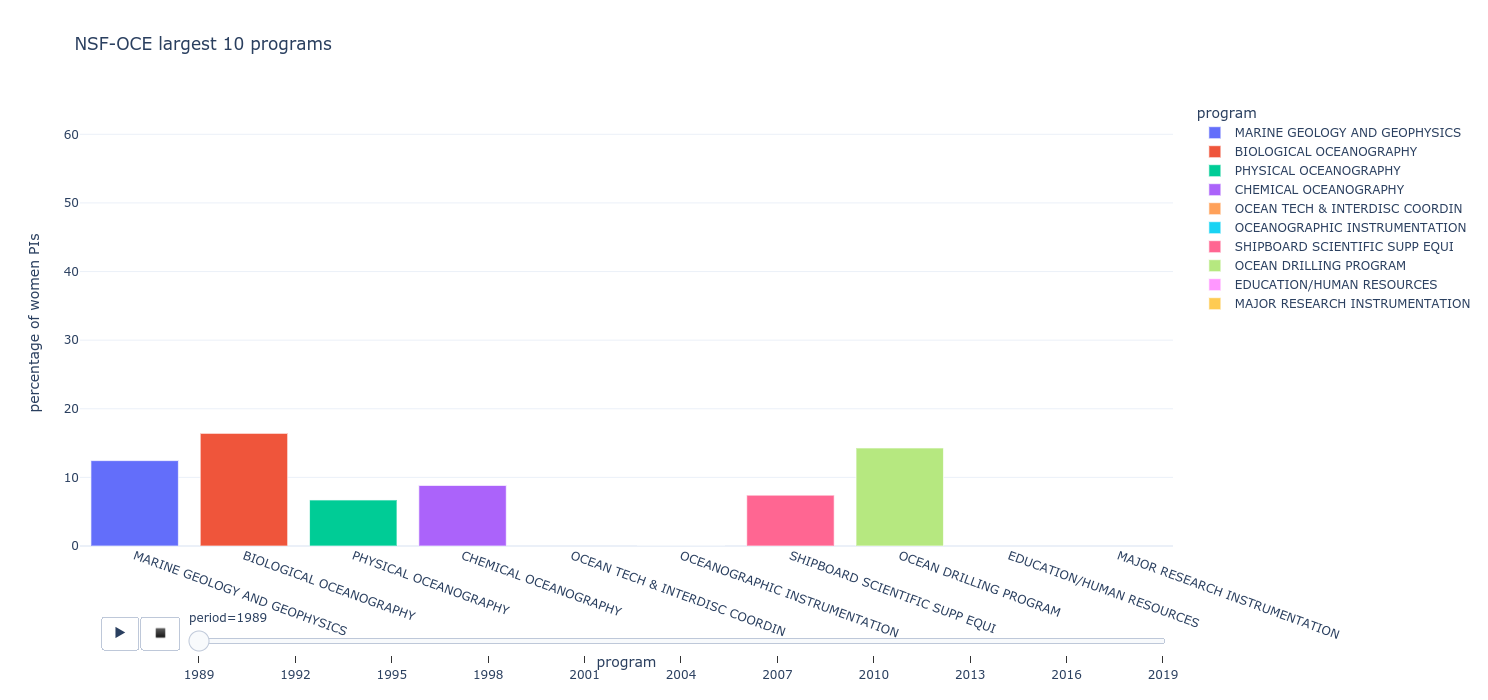

In [6]:
df = df_pi.reindex(top10_programs.index, level=1).reset_index().rename(columns={0:'percentage'})
fig = px.bar(df, x='program', y='percentage', color='program', width=900, height=700, title='NSF-OCE largest 10 programs', 
             animation_frame='period', animation_group='program', range_y=[0, 65])
fig.update_layout(yaxis=dict(title='percentage of women PIs'))
fig.update_xaxes(tickangle=20)
fig.show()

The figure below shows in more detail the percentage of women co-PIs for the 10 largest NSF-OCE programs from 1987 to 2019. The data is grouped and averaged in 3-year periods. The year shown in the slide bar represents the end of the 3-year period.

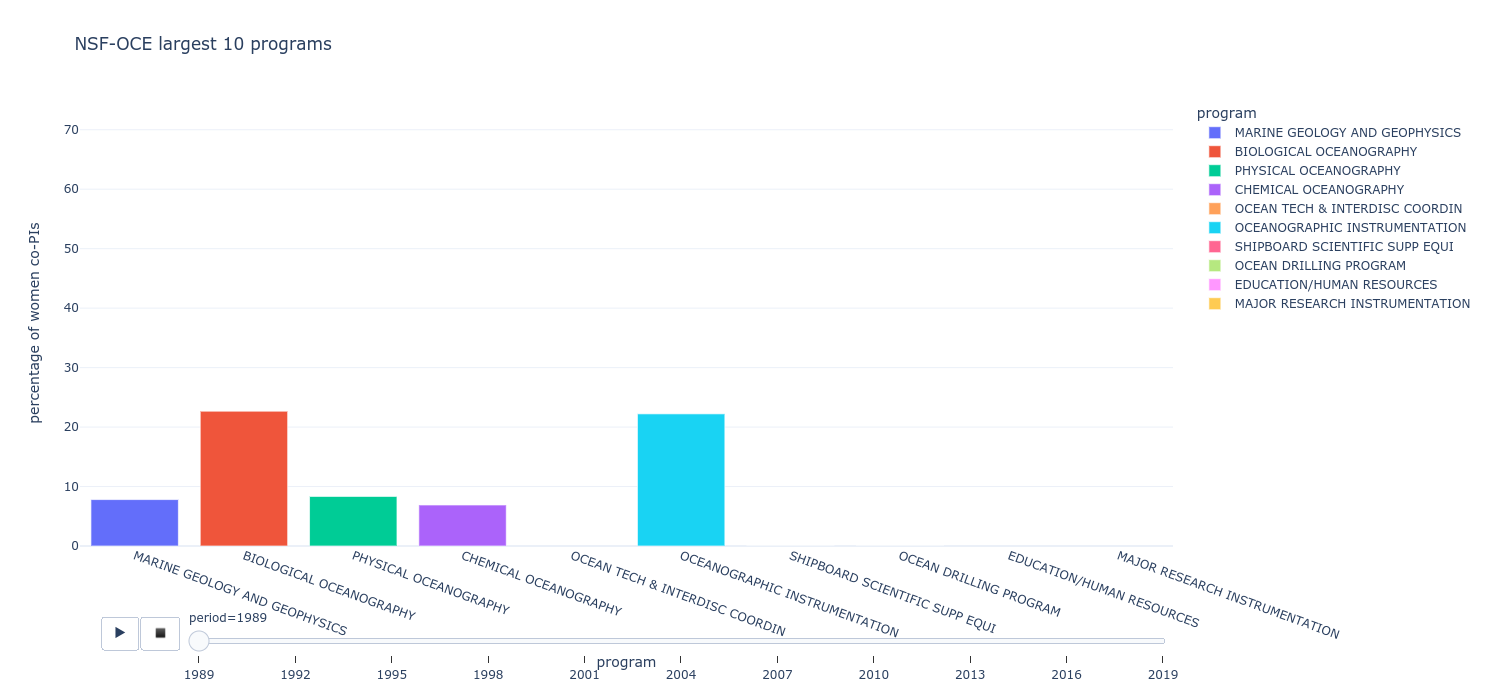

In [7]:
df = df_copi.reindex(top10_programs.index, level=1).reset_index().rename(columns={0:'percentage'})
fig = px.bar(df, x='program', y='percentage', color='program', width=900, height=700, title='NSF-OCE largest 10 programs',
             animation_frame='period', animation_group='program', range_y=[0, 75])
fig.update_layout(yaxis=dict(title='percentage of women co-PIs'))
fig.update_xaxes(tickangle=20)
fig.show()

The figure below shows in more detail the relative proportion or percentage of the 10 largest NSF-OCE programs within each gender (PI) from 1987 to 2019. The data is grouped and averaged in 3-year periods. The year shown in the slide bar represents the end of the 3-year period.

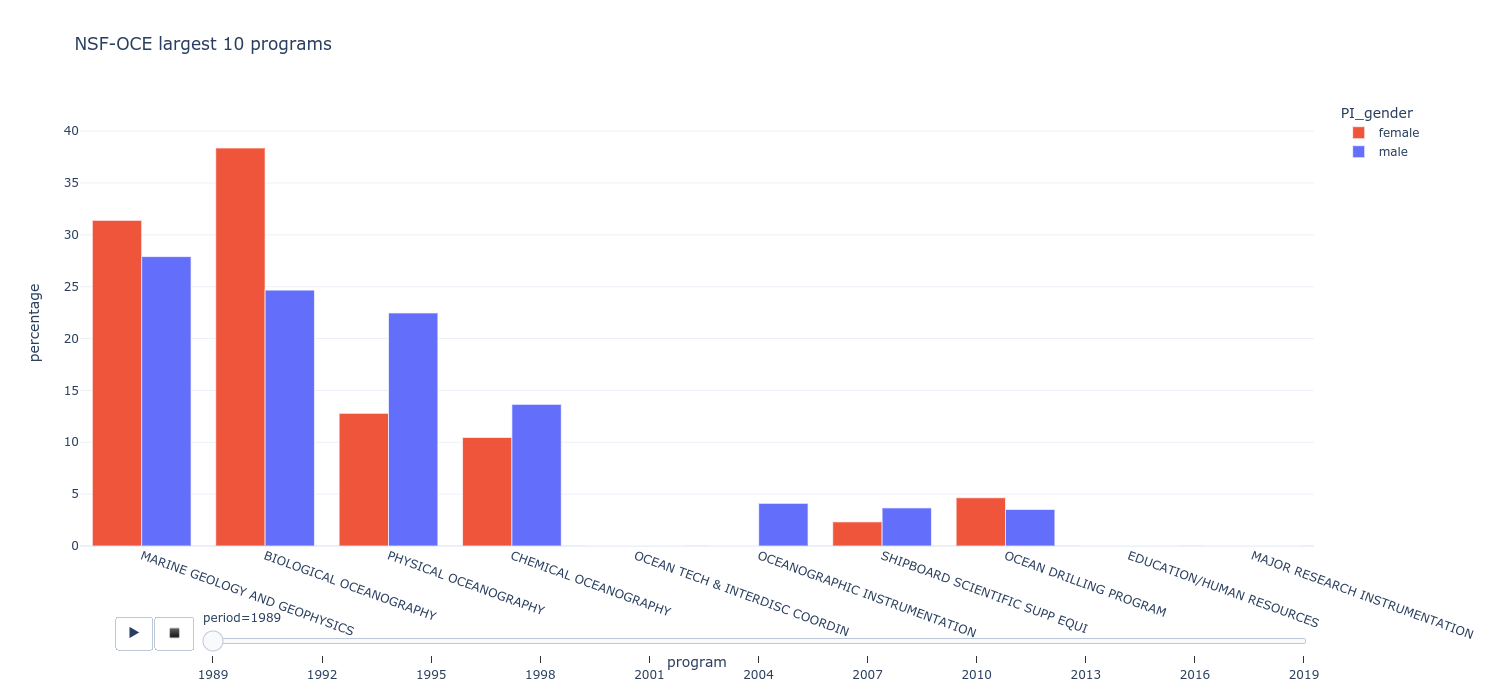

In [8]:
iterables = [range(1989,2021,3), top10_programs.index]
inds = pd.MultiIndex.from_product(iterables, names=['period', 'program']) # reorder indices

df = awards_top10.groupby(['period', 'program', 'PI_gender'])['Abstract'].count().unstack().fillna(0)
# compute the ratio between the percentage of awards allocated by women PIs and men PIs to each topic per year
df_work = df.divide(df.groupby('period').sum(), axis=0) * 100
df_work = df_work.reindex(inds).fillna(0)
df_work = df_work.stack().rename('percentage').reset_index()
df_work[:25]

fig = px.bar(df_work, x='program', y='percentage', color='PI_gender', width=800, height=700, title='NSF-OCE largest 10 programs',
             animation_frame='period', animation_group='program', range_y=[0, 43], barmode='group', color_discrete_sequence=['#EF553B','#636EFA'])
fig.update_xaxes(tickangle=20)
fig.show()

## Research topics

We applied topic modeling to the award abstracts to uncover underlying research topics. The figure below shows the word cloud plots for the 21 topics we extracted.

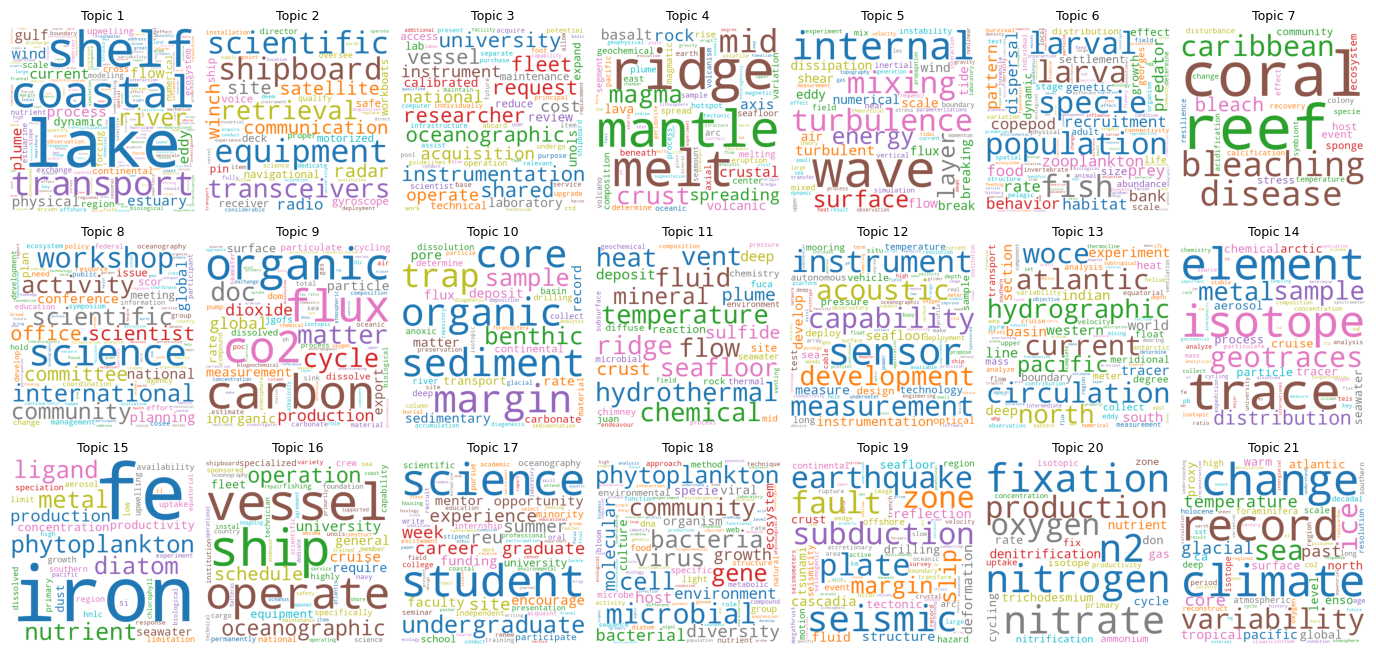

In [9]:
import matplotlib.pyplot as plt
import wordcloud
plt.rcParams['figure.dpi'] = 100

sort_by_feature = np.argsort(nmf_components, axis=1)[:,::-1]
nmf_components_sorted = np.take_along_axis(nmf_components, sort_by_feature, axis=1)
feature_names_sorted = feature_names[sort_by_feature]
word_freq = np.round(nmf_components_sorted * 5).astype(int)

topics = {}
for t in range(1,22):
    topics[t] = []
    for n in range(len(feature_names)):
        if word_freq[t-1,n] > 0:
            topics[t] = topics[t] + [feature_names_sorted[t-1,n]] #* word_freq[t-1,n]

s = 1.25
fig, axs = plt.subplots(3, 7, figsize=(14*s,6.75*s))
fig.subplots_adjust(wspace=0.05, hspace=0.05)
for ax, t in zip(axs.ravel(), range(1,22)):
    wc = wordcloud.WordCloud(background_color='white', width=500, height=500, colormap=plt.cm.tab10,
                         random_state=42, relative_scaling=0.5).generate(' '.join(topics[t]))
    _ = ax.imshow(wc)
    _ = ax.axis('off')
    _ = ax.set_title('Topic {}'.format(t), fontsize=9)

## Women's participation across research topics

In [10]:
# compute percentage of women PIs per year & topic
df = awards.groupby(['period', 'topic', 'PI_gender'])['Abstract'].count().unstack().fillna(0)
df_pi_topics = df.divide(df.sum(axis=1), axis=0) * 100 
df_pi_topics = df_pi_topics['female'].unstack().stack(dropna=False)

# compute the ratio between the percentage of awards allocated by women PIs and men PIs to each topic per year
df_work = df.divide(df.groupby('period').sum(), axis=0)
df_ratio_topics = df_work.female/df_work.male
df_ratio_topics = df_ratio_topics.unstack().stack(dropna=False)
df_ratio_topics = df_ratio_topics.replace([np.inf, -np.inf], np.nan)

# compute percentage of women co-PIs per year & topic
df_copi_topics = awards.groupby(['period', 'topic'])['co-PI_female_frac'].mean().fillna(0) * 100
df_copi_topics = df_copi_topics.unstack().stack(dropna=False)

# compute number of proposals per year & topic
df_num_topics = awards.groupby(['period', 'topic'])['Abstract'].count().fillna(0)
df_num_topics = df_num_topics.unstack().stack(dropna=False).fillna(0)

# df_pi_topics = df_pi_topics.unstack().rolling(window=3, center=True, min_periods=1).mean().stack()
# df_copi_topics = df_copi_topics.unstack().rolling(window=3, center=True, min_periods=1).mean().stack()
# df_ratio_topics = df_ratio_topics.unstack().rolling(window=3, center=True, min_periods=1).mean().stack()
# df_num_topics = df_num_topics.unstack().rolling(window=3, center=True, min_periods=1).mean().stack()
# df_num_topics[df_num_topics == 0] = np.nan
# df_num_topics = df_num_topics.round()

# combine data into one dataframe
topic_order = np.array([4,10,11,19,21,6,7,15,18,1,5,13,9,14,20,3,12,2,16,8,17]) # order topics by program
topic_name_mapping = {n+1:s for n,s in enumerate(topic_names_r)}
iterables = [range(1989,2021,3), topic_order]
# iterables = [range(1988,2019), topic_order]
inds = pd.MultiIndex.from_product(iterables, names=['year', 'topic']) # reorder indices
df_topics = pd.concat([df_pi_topics, df_copi_topics, df_ratio_topics, df_num_topics],
                      keys=['PI', 'co-PI', 'ratio', 'number'], axis=1).reindex(inds).reset_index()
df_topics['topic name'] = df_topics['topic'].map(topic_name_mapping)

The figure below shows the percentage of women PIs vs co-PIs for 21 identified research topics from 1987 to 2019. The marker color represents the ratio between the percentage of awards allocated by women PIs and men PIs to that topic. A ratio greater than one indicates that the proportion of women PIs in that category is higher than that of men PIs. The annual data can be noisy due to the small number of awards (1 to 3) in certain categories in a given year. So in the visualization below we group and average the data in 3-year periods. The year shown in the slide bar represents the end of the 3-year period.

The rate of change in women's participation varies significantly across different research topics. Consistent with what we see in the programs, women’s participation in the topics related to EHR (topics 8 and 17) shows remarkable growth and achieves near parity with men. While the topics associated with shipboard equipment and instrumentation and ship operations (topics 2, 3 and 16) show relatively small changes in women's representation. All 21 topics show a net increase in women's representation between 1987 and 2019. However, changes in specific topics over the short term are uneven and erratic with with increases in the percentage of women PIs and co-PIs followed by declines and vice-versa. Similar to what we see in the NSF-OCE programs, women’s representation tends to be higher in the topics for which the proportion of women PIs is larger than that of men, and vice-versa.

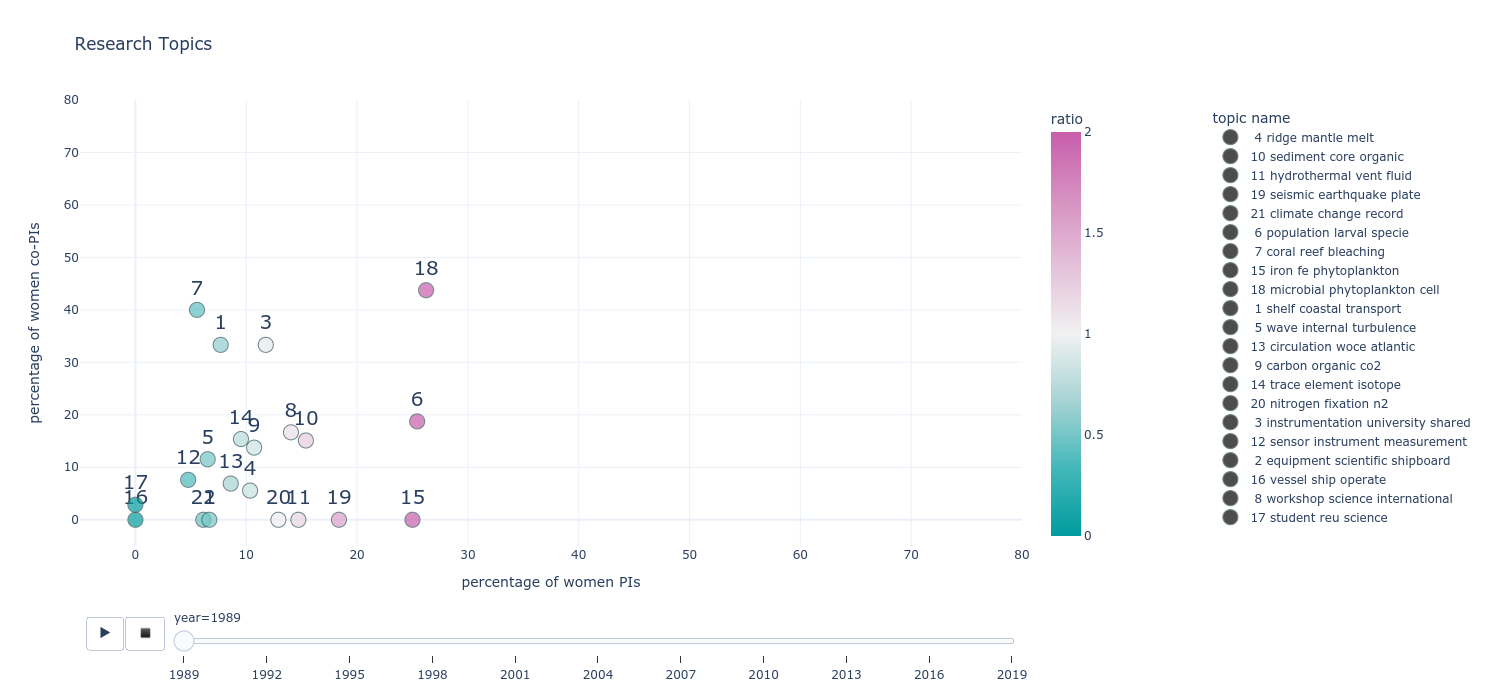

In [11]:
fig = px.scatter(df_topics, x='PI', y='co-PI', animation_frame='year', animation_group='topic', text='topic',
                 color='ratio', range_x=[-5,80], range_y=[-5,80], width=900, height=700, symbol='topic name', symbol_sequence=['circle'],
                 color_continuous_scale='Tropic', color_continuous_midpoint=1, range_color=(0,2), title='Research Topics',
                 hover_data={'ratio':':.2f', 'PI':':.1f', 'co-PI':':.1f', 'number':':d'}, opacity=0.7)
fig.update_traces(textposition='top center', textfont_size=20, marker=dict(size=15,line=dict(width=1,color='DarkSlateGrey')))
fig.update_layout(legend=dict(yanchor='top', y=0.99, xanchor='left', x=1.2),
                  xaxis=dict(title='percentage of women PIs', tickvals=np.arange(0,90,10)), yaxis=dict(title='percentage of women co-PIs'))
fig.update_layout(uniformtext_minsize=100, uniformtext_mode='hide')
fig.show()

The figure below shows in more detail the percentage of women PIs for the 21 identified research topics from 1987 to 2019. The data is grouped and averaged in 3-year periods. The year shown in the slide bar represents the end of the 3-year period.

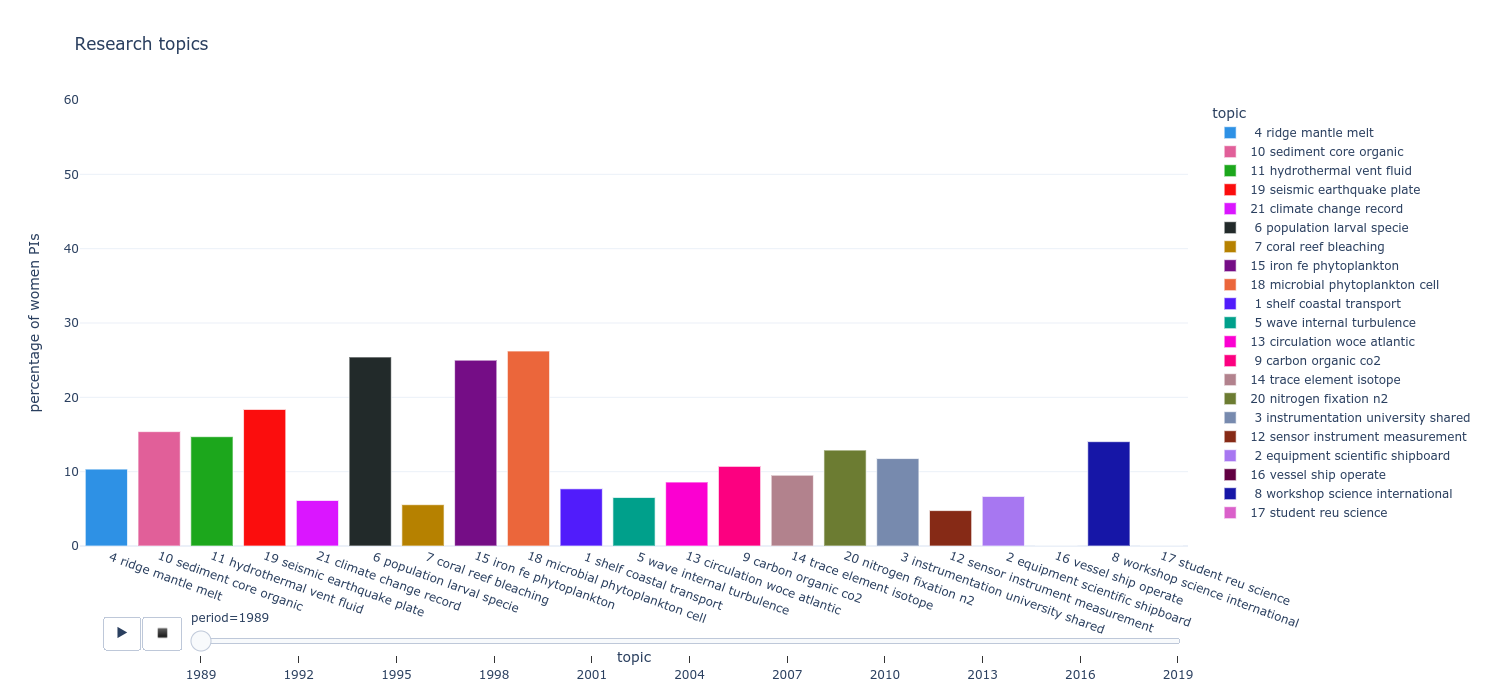

In [12]:
df = df_pi_topics.reindex(topic_order, level=1).reset_index().rename(columns={0:'percentage'})
df['topic'] = df.topic.map(topic_name_mapping)
fig = px.bar(df, x='topic', y='percentage', color='topic', width=900, height=700, title='Research topics', 
             animation_frame='period', animation_group='topic', range_y=[0, 60], color_discrete_sequence=px.colors.qualitative.Dark24)
fig.update_layout(yaxis=dict(title='percentage of women PIs'))
fig.update_xaxes(tickangle=20)
fig.show()

The figure below shows in more detail the percentage of women co-PIs for the 21 identified research topics from 1987 to 2019. The data is grouped and averaged in 3-year periods. The year shown in the slide bar represents the end of the 3-year period.

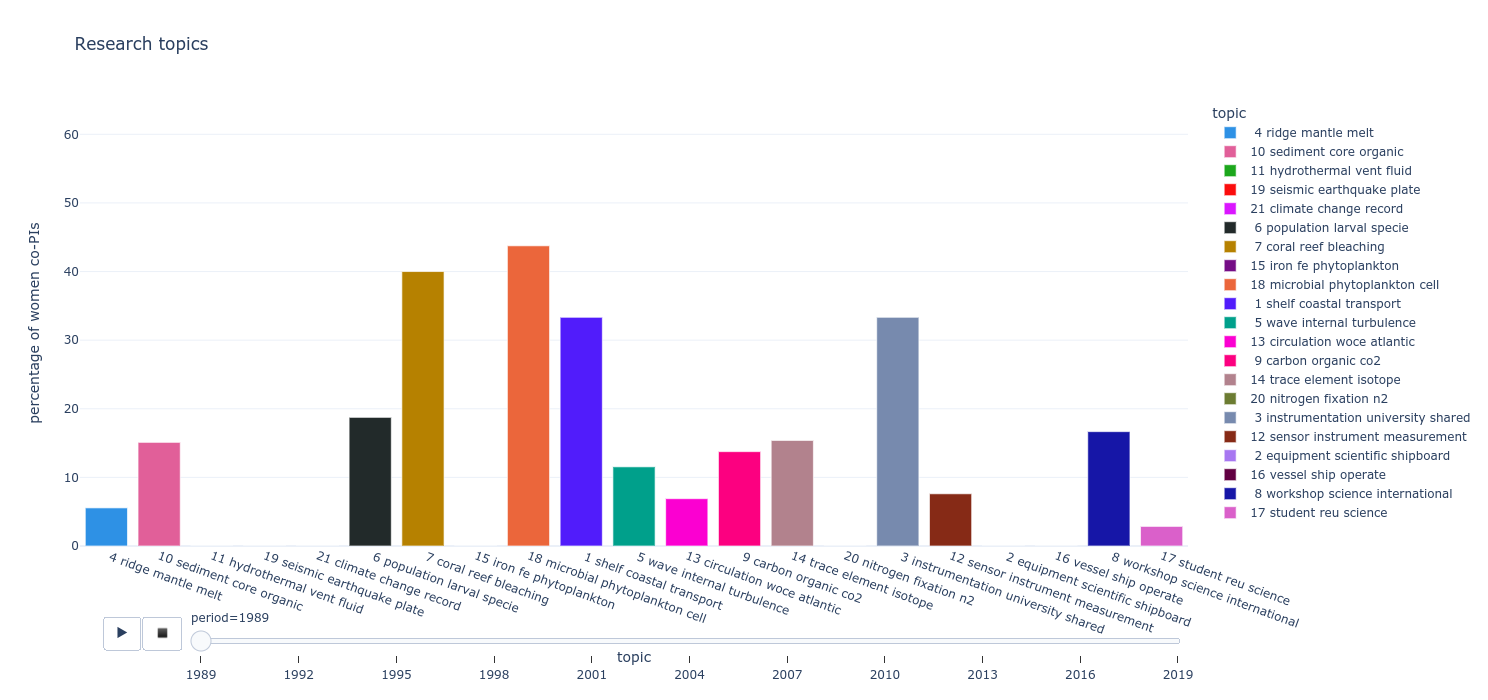

In [13]:
df = df_copi_topics.reindex(topic_order, level=1).reset_index().rename(columns={0:'percentage'})
df['topic'] = df.topic.map(topic_name_mapping)
fig = px.bar(df, x='topic', y='percentage', color='topic', width=900, height=700, title='Research topics', 
             animation_frame='period', animation_group='topic', range_y=[0, 65], color_discrete_sequence=px.colors.qualitative.Dark24)
fig.update_layout(yaxis=dict(title='percentage of women co-PIs'))
fig.update_xaxes(tickangle=20)
fig.show()

The figure below shows in more detail the relative proportion or percentage of the 21 research topics within each gender (PI) from 1987 to 2019. The data is grouped and averaged in 3-year periods. The year shown in the slide bar represents the end of the 3-year period.

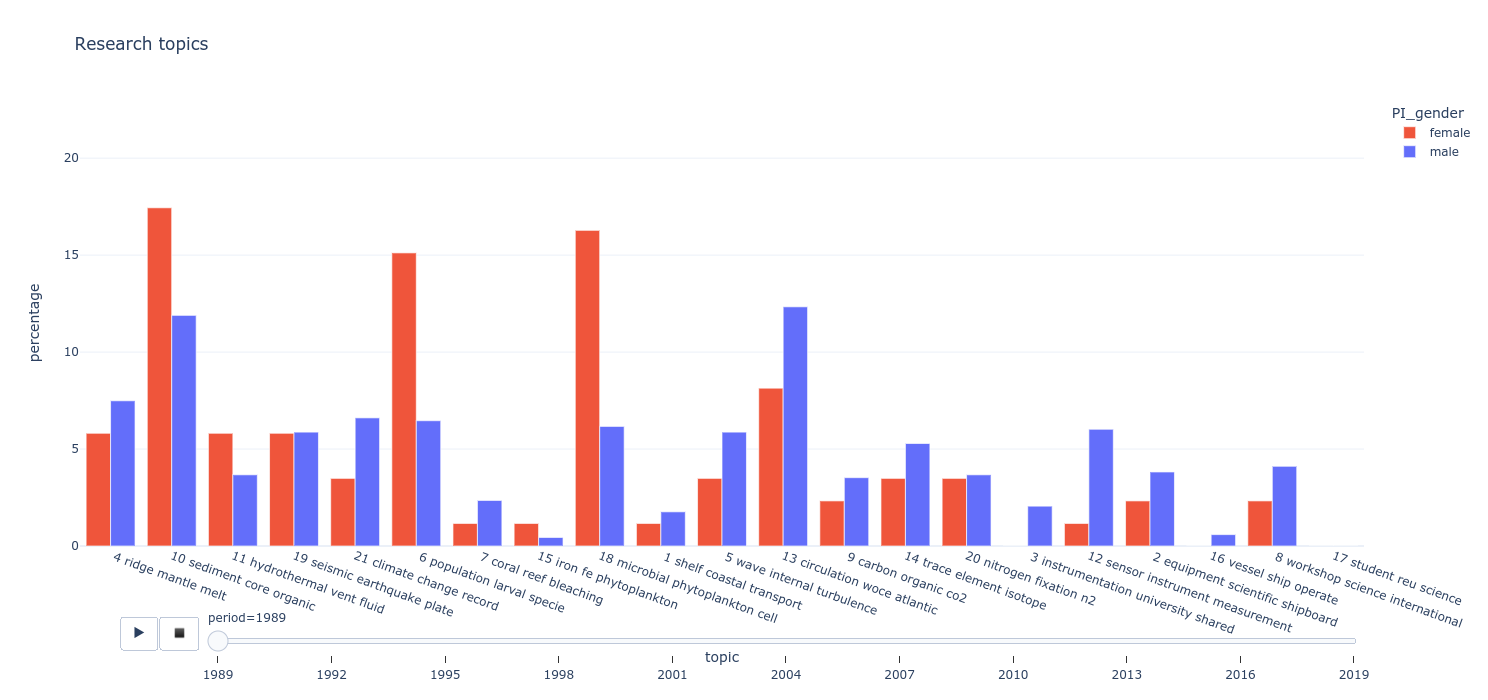

In [14]:
iterables = [range(1989,2021,3), topic_order]
inds = pd.MultiIndex.from_product(iterables, names=['period', 'topic']) # reorder indices

df = awards_top10.groupby(['period', 'topic', 'PI_gender'])['Abstract'].count().unstack().fillna(0)
# compute the ratio between the percentage of awards allocated by women PIs and men PIs to each topic per year
df_work = df.divide(df.groupby('period').sum(), axis=0) * 100
df_work = df_work.reindex(inds).fillna(0)
df_work = df_work.stack().rename('percentage').reset_index()
df_work['topic'] = df_work.topic.map(topic_name_mapping)

fig = px.bar(df_work, x='topic', y='percentage', color='PI_gender', width=800, height=700, title='Research topics',
             animation_frame='period', animation_group='topic', range_y=[0, 23], barmode='group', color_discrete_sequence=['#EF553B','#636EFA'])
fig.update_xaxes(tickangle=20)
fig.show()

## Women's participation across award types

The types of awards identified in the data are:

- Standard awards
- Collaborative Research
- EAGER: EArly-concept Grant For Exploratory Research
- RAPID: Rapid Response Research
- REU: Research Experience for Undergraduates
- RUI: Research in Undergraduate Institutions
- CAREER: Faculty Early Career Development

In [15]:
awards_atype = awards[awards.award_type!='POWRE']
awards_atype = awards_atype[awards_atype.award_type!='CMG']

atypes = pd.DataFrame({'number of awards': awards_atype.award_type.value_counts()}) # number of awards in each type

# compute percentage of women PIs per year & award type
df = awards_atype.groupby(['period', 'award_type', 'PI_gender'])['Abstract'].count().unstack().fillna(0)
df_pi_atype = df.divide(df.sum(axis=1), axis=0) * 100 
df_pi_atype = df_pi_atype['female'].unstack().stack(dropna=False)

# compute the ratio between the percentage of awards allocated by women PIs and men PIs to each award type per year
df_work = df.divide(df.groupby('period').sum(), axis=0)
df_ratio_atype = df_work.female/df_work.male
df_ratio_atype = df_ratio_atype.unstack().stack(dropna=False)
df_ratio_atype = df_ratio_atype.replace([np.inf, -np.inf], np.nan)

# compute percentage of women co-PIs per year & award type
df_copi_atype = awards_atype.groupby(['period', 'award_type'])['co-PI_female_frac'].mean().fillna(0) * 100
df_copi_atype = df_copi_atype.unstack().stack(dropna=False)

# compute number of proposals per year & award type
df_num_atype = awards_atype.groupby(['period', 'award_type'])['Abstract'].count().fillna(0)
df_num_atype = df_num_atype.unstack().stack(dropna=False).fillna(0)

# df_pi_atype = df_pi_atype.unstack().rolling(window=3, center=True, min_periods=1).mean().stack()
# df_copi_atype = df_copi_atype.unstack().rolling(window=3, center=True, min_periods=1).mean().stack()
# df_ratio_atype = df_ratio_atype.unstack().rolling(window=3, center=True, min_periods=1).mean().stack()
# df_num_atype = df_num_atype.unstack().rolling(window=3, center=True, min_periods=1).mean().stack()
# df_num_atype[df_num_atype == 0] = np.nan
# df_num_atype = df_num_atype.round()

# combine data into one dataframe
iterables = [range(1989,2021,3), atypes.index]
# iterables = [range(1988,2019), atypes.index]
inds = pd.MultiIndex.from_product(iterables, names=['year', 'award_type']) # reorder indices
df_atypes = pd.concat([df_pi_atype, df_copi_atype, df_ratio_atype, df_num_atype], keys=['PI', 'co-PI', 'ratio', 'number'], axis=1).reindex(inds).reset_index()

The figure below shows the percentage of women PIs vs co-PIs for the different NSF-OCE award types from 1987 to 2019. The marker color represents the ratio between the percentage of awards allocated by women PIs and men PIs to that award type. A ratio greater than one indicates that the proportion of women PIs in that category is higher than that of men PIs. The annual data can be noisy due to the small number of awards (1 to 3) in certain categories in a given year. So in the visualization below we group and average the data in 3-year periods. The year shown in the slide bar represents the end of the 3-year period.

Women’s representation has increased at different rates across the different award types during the study period. Overall, women’s participation either as PIs or co-PIs has grown more noticeably in EAGER, RAPID, REU, CAREER and RUI awards than in standard and Collaborative Research awards, although there are strong fluctuations from year to year. The higher proportion of women PIs, relative to men, in EAGER, RAPID, REU, CAREER and RUI awards in the last few years indicates that women are making better use of these smaller types of awards and that they have a more diversified “portfolio” of research and research-related activities than men.

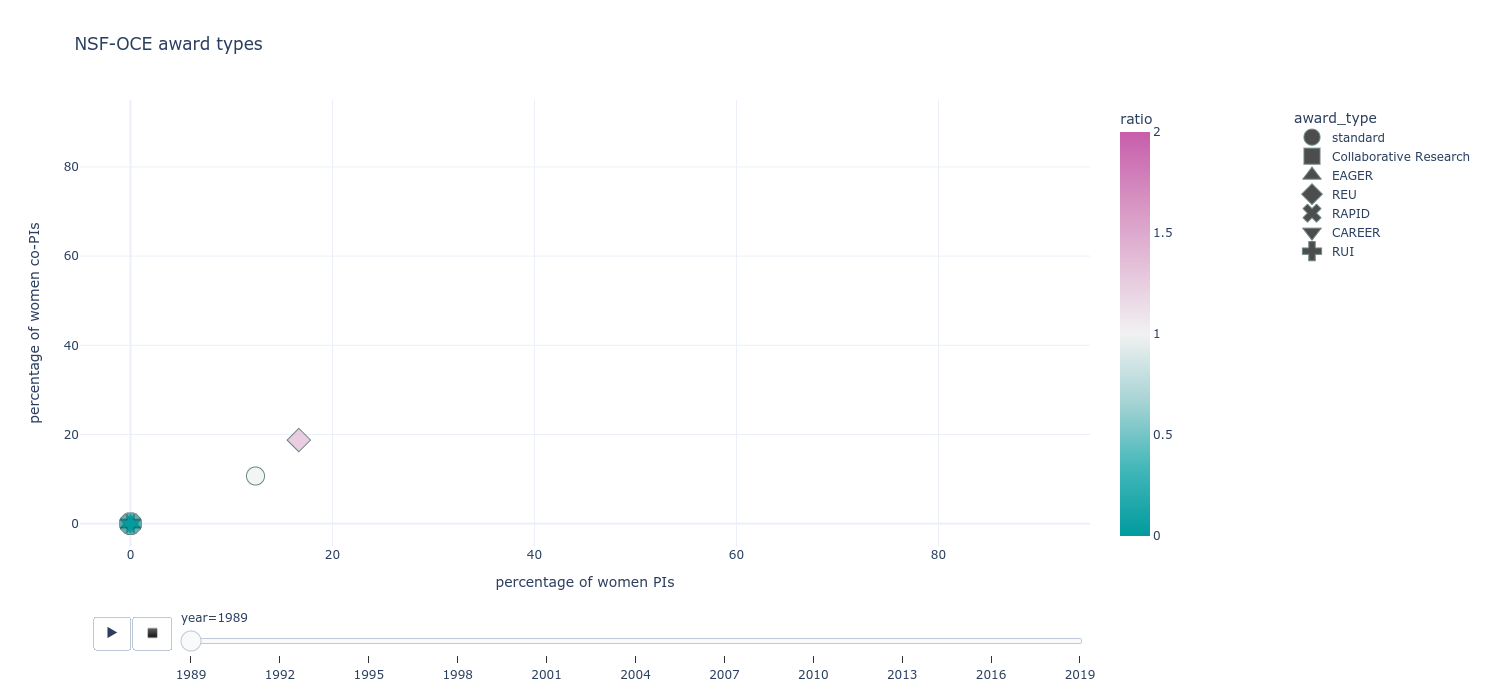

In [16]:
fig = px.scatter(df_atypes, x='PI', y='co-PI', animation_frame='year', animation_group='award_type', symbol='award_type',
                 color='ratio', range_x=[-5,95], range_y=[-5,95], width=900, height=700, symbol_sequence=symbols,
                 color_continuous_scale='Tropic', color_continuous_midpoint=1, title='NSF-OCE award types',
                 hover_data={'ratio':':.2f', 'PI':':.1f', 'co-PI':':.1f', 'number':':d'}, opacity=0.7)
fig.update_traces(marker=dict(size=18,line=dict(width=1,color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.update_layout(legend=dict(yanchor='top', y=0.99, xanchor='left', x=1.2),
                  xaxis=dict(title='percentage of women PIs'), yaxis=dict(title='percentage of women co-PIs'))
fig.show()

The figure below shows in more detail the percentage of women PIs for the different NSF-OCE award types from 1987 to 2019. The data is grouped and averaged in 3-year periods. The year shown in the slide bar represents the end of the 3-year period.

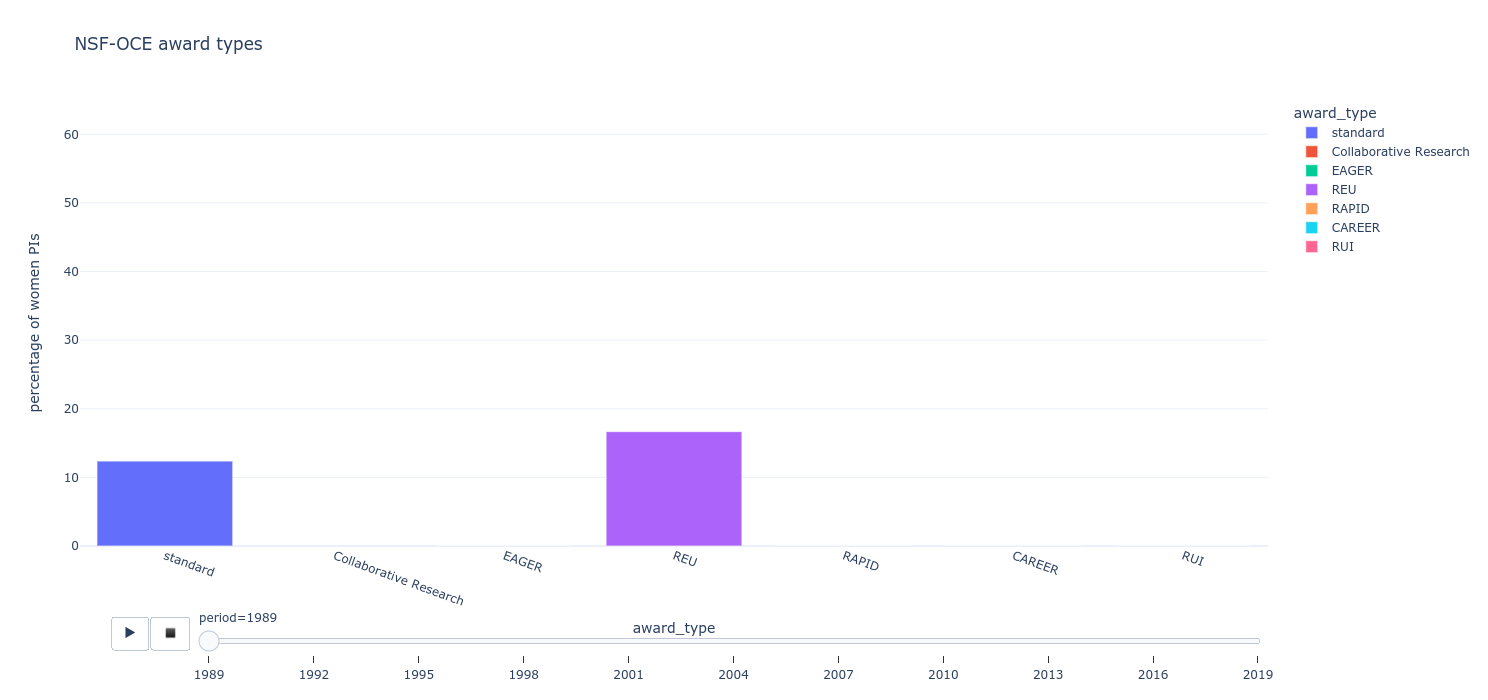

In [17]:
df = df_pi_atype.reindex(atypes.index, level=1).reset_index().rename(columns={0:'percentage'})
fig = px.bar(df, x='award_type', y='percentage', color='award_type', width=800, height=700, title='NSF-OCE award types', 
             animation_frame='period', animation_group='award_type', range_y=[0, 65])
fig.update_layout(yaxis=dict(title='percentage of women PIs'))
fig.update_xaxes(tickangle=20)
fig.show()

The figure below shows in more detail the percentage of women co-PIs for the different NSF-OCE award types from 1987 to 2019. The data is grouped and averaged in 3-year periods. The year shown in the slide bar represents the end of the 3-year period.

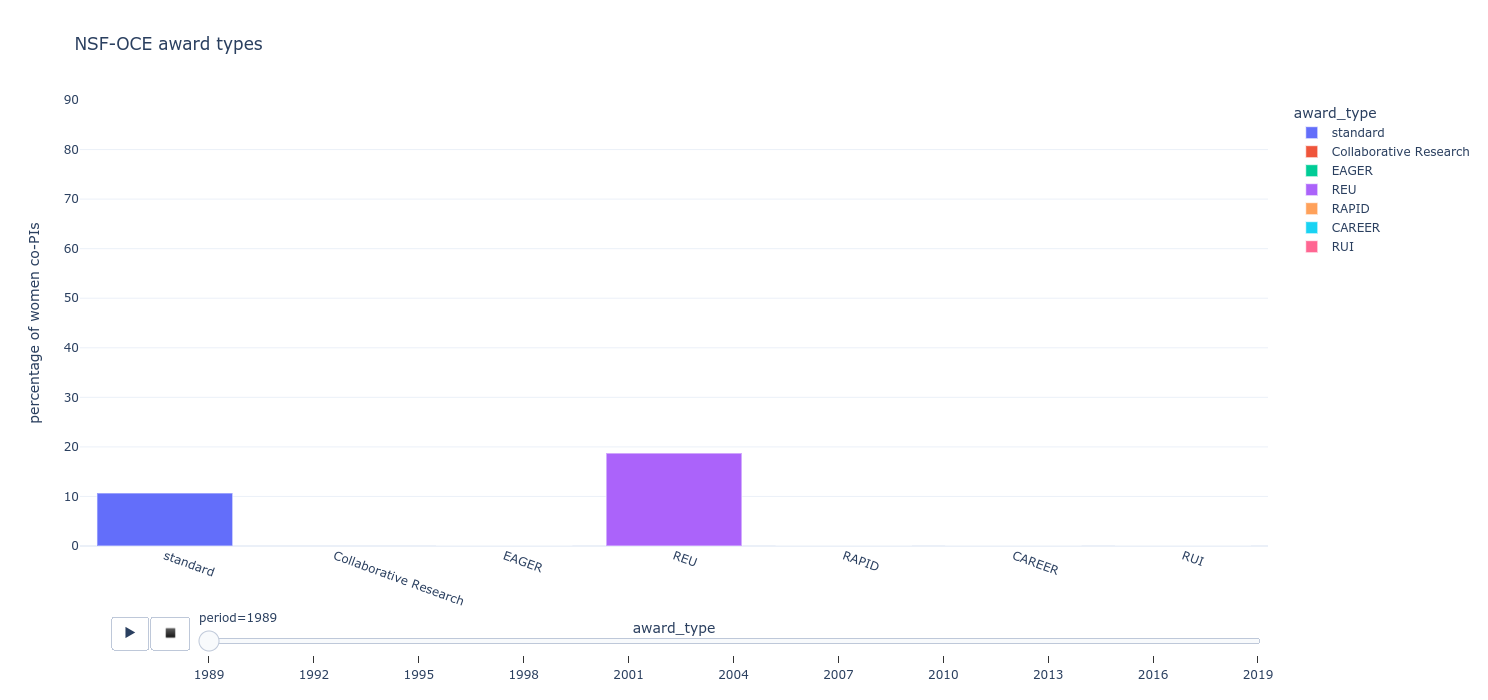

In [18]:
df = df_copi_atype.reindex(atypes.index, level=1).reset_index().rename(columns={0:'percentage'})
fig = px.bar(df, x='award_type', y='percentage', color='award_type', width=800, height=700, title='NSF-OCE award types', 
             animation_frame='period', animation_group='award_type', range_y=[0, 90])
fig.update_layout(yaxis=dict(title='percentage of women co-PIs'))
fig.update_xaxes(tickangle=20)
fig.show()

The figure below shows in more detail the relative proportion or percentage of the different NSF-OCE award types within each gender (PI) from 1987 to 2019. The data is grouped and averaged in 3-year periods. The year shown in the slide bar represents the end of the 3-year period.

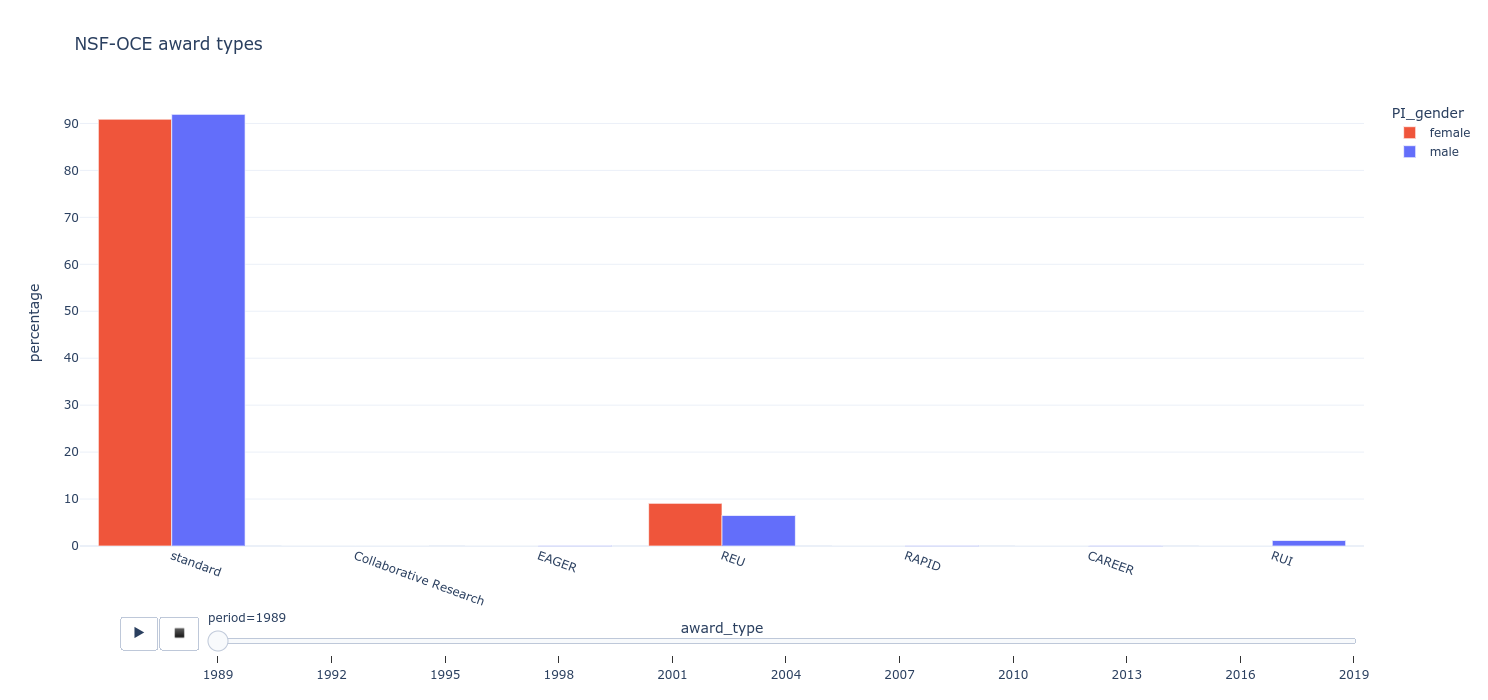

In [19]:
iterables = [range(1989,2021,3), atypes.index]
inds = pd.MultiIndex.from_product(iterables, names=['period', 'award_type']) # reorder indices

df = awards_atype.groupby(['period', 'award_type', 'PI_gender'])['Abstract'].count().unstack().fillna(0)
# compute the ratio between the percentage of awards allocated by women PIs and men PIs to each topic per year
df_work = df.divide(df.groupby('period').sum(), axis=0) * 100
df_work = df_work.reindex(inds).fillna(0)
df_work = df_work.stack().rename('percentage').reset_index()

fig = px.bar(df_work, x='award_type', y='percentage', color='PI_gender', width=800, height=700, title='NSF-OCE award types',
             animation_frame='period', animation_group='award_type', range_y=[0, 95], barmode='group', color_discrete_sequence=['#EF553B','#636EFA'])
fig.update_xaxes(tickangle=20)
fig.show()

In [20]:
# df = awards[(awards.PI_gender.notnull()) & (awards.tot_amount_adjusted>1000)]
# fig = px.box(df, x='PI_gender', y='tot_amount_adjusted', color='PI_gender', width=800, height=700,
#              range_y=[-1.e+5,2.0e+6], title='All NSF-OCE awards')
# fig.update_traces(marker=dict(opacity=0))
# fig.update_layout(xaxis=dict(title='PI gender'), yaxis=dict(title='award size (U.S. dollars)'))
# fig.show()

In [21]:
# top10_programs = awards.program.value_counts()[:10]
# awards_top10 = awards[awards.program.isin(top10_programs.index)]
# awards_top10 = awards_top10[awards_top10.PI_gender.notnull()]
# df = awards_top10[(awards_top10.program.notnull()) & (awards_top10.tot_amount_adjusted>1000)]

# fig = px.box(df, x='program', y='tot_amount_adjusted', color='PI_gender', width=800, height=700, range_y=[-1.e+5,2.5e+6],
#              category_orders={'program':top10_programs.index}, title='Top 10 NSF-OCE programs')
# fig.update_traces(marker=dict(opacity=0))
# fig.update_layout(yaxis=dict(title='award size (U.S. dollars)'))
# fig.show()

In [22]:
# df = awards[(awards.PI_gender.notnull()) & (awards.tot_amount_adjusted>1.+6)]
# fig = px.histogram(awards_top10[awards_top10.year>2008], x='program', histnorm='percent', color='PI_gender', barmode='group',
#                    category_orders={'program':top10_programs.index}, 
#                    width=800, height=700)
# fig.show()

In [23]:
# topic_map = {t+1:topic_names_r[t] for t in range(len(topic_names_r))}
# topic_order = np.array([4,10,11,19,21,6,7,15,18,1,5,13,9,14,20,3,12,2,16,8,17]) # order topics by program
# awards['topic_name'] = awards.topic.map(topic_map)
# df = awards[(awards.PI_gender.notnull()) & (awards.tot_amount_adjusted>1000)]

# fig = px.box(df, x='topic_name', y='tot_amount_adjusted', color='PI_gender', width=800, height=700, range_y=[-1.e+5,12e+6],
#              category_orders={'topic_name':topic_names_r[topic_order-1]}, title='Research topics')
# fig.update_traces(marker=dict(opacity=0))
# fig.update_layout(yaxis=dict(title='award size (U.S. dollars)'))
# fig.update_xaxes(tickangle=30)
# fig.show()

In [24]:
# awards_clean = awards[awards.award_type!='CMG']
# awards_clean = awards_clean[awards_clean.award_type!='POWRE']
# atypes = pd.DataFrame({'number of awards': awards_clean.award_type.value_counts()})
# df = awards_clean[(awards_clean.PI_gender.notnull()) & (awards_clean.tot_amount_adjusted>1000)]

# fig = px.box(df, x='award_type', y='tot_amount_adjusted', color='PI_gender', width=800, height=700, range_y=[-1.e+5, 2.3e+6],
#              category_orders={'award_type':atypes.index}, title='Award types')
# fig.update_traces(marker=dict(opacity=0))
# fig.update_layout(xaxis=dict(title='award type'), yaxis=dict(title='award size (U.S. dollars)'))
# fig.show()